In [40]:
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import re
import math
import unicodedata
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn import preprocessing
import warnings
from sklearn.cross_validation import cross_val_score
%matplotlib inline
warnings.filterwarnings("ignore")
# various options in pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
def doltoint(st):
    try:
        return float(''.join(''.join(st.split(',')).split('$')))
    except:
        return np.NaN
def OpGrossFix(st):
    return float(st.split('(')[0])
def prettyBudg(st):
    if st[-7::]=='million':
        return float(st.split(' ')[0].split('$')[1])*1000000
    elif st == 'N/A':
        return np.NaN
    else:
        return doltoint(st)
def prettyRun(st):
    t1 = []
    for i in st.split(' '):
        try:
            t1.append(int(i))
        except:
            pass     
    if len(t1)==2:
        return 60*t1[0] + t1[1]
    elif len(t1) == 1:
        return t1[0]
def month(st):
    if(st=='January'):
        return '01'
    elif(st=='February'):
        return '02'
    elif(st=='March'):
        return '03'
    elif(st=='April'):
        return '04'
    elif(st=='May'):
        return '05'
    elif(st=='June'):
        return '06'
    elif(st=='July'):
        return '07'
    elif(st=='August'):
        return '08'
    elif(st=='September'):
        return '09'
    elif(st=='October'):
        return '10'
    elif(st=='November'):
        return '11'
    elif(st=='December'):
        return '12'
    else:
        return 'SOMETHING BAD HAPPENED'
def cleanDay(st):
    if(len(st)==1):
        return '0' + st
    else:
        return st
def cleanDate(st):
    t=st.split(' ')
    return month(t[0])+cleanDay(t[1][:-1])+t[2]
df = pd.read_json('movies3t.json', orient = 'records', dtype={"url":str})
df = df[df.totalDomesticGross != 'Missing']
df = df[df.OpGross != 'NaN']
df = df[df.Budget != 'N/A']
df['OpGross'] = [OpGrossFix(x) for x in df['OpGross']]
df['noTheaters'] = [int(re.sub('[^0-9]','',x)) for x in df['noTheaters']]
df['RunTime'] = [ prettyRun(x) for x in df['RunTime']]
df['avOpGrossPTheater'] = [doltoint(x) for x in df['avOpGrossPTheater']]
df['totalDomesticGross'] = [doltoint(x) for x in df['totalDomesticGross']]
df['Budget'] = [prettyBudg(x) for x in df['Budget']]
df['Distributor'] = [str(x) for x in df['Distributor']]
df['Genre'] = [str(x) for x in df['Genre']]
df['Rating'] = [str(x) for x in df['Rating']]
df['actor'] = [unicodedata.normalize('NFKD', x) for x in df['actor']]
df['composer'] = [str(x) for x in df['composer']]
df['director'] = [unicodedata.normalize('NFKD', x) for x in df['director']]
df['name'] = [unicodedata.normalize('NFKD',x) for x in df['name']]
df['writer'] = [unicodedata.normalize('NFKD',x) for x in df['writer']]
df['ReleaseDate'] = [str(x) for x in df['ReleaseDate']]
df['ReleaseDate'] = pd.to_datetime([cleanDate(x) for x in df['ReleaseDate']], format = '%m%d%Y')

In [41]:
#From above, data is now clean. Let's examine the categorical data:
# Distributor, Genre, Rating, actor, composer, director, and writer
print(len(set(df['Distributor'])))
print(len(set(df['Genre'])))
print(len(set(df['Rating'])))
print(len(set(df['actor'])))
print(len(set(df['composer'])))
print(len(set(df['director'])))
print(len(set(df['writer'])))

170
64
7
790
147
735
510


In [42]:
#Other than Rating, these categorical variables might have too many values to be useful.  Let's check this out further.
df1 = df.groupby('Distributor').totalDomesticGross.agg(['count','mean','std'])
df1 = df1[[not np.isnan(x) for x in df1['std']]]
df1 = df1[[x>(1.645 * y) for x,y in zip(df1['mean'], df1['std'])]]
print(df1)

                       count       mean        std
Distributor                                       
Apparition                 4  7.323e+06  3.855e+06
BH Tilt                    4  6.536e+06  2.777e+06
Dimension Films           15  6.207e+07  3.672e+07
MGM (Weinstein)            2  1.999e+07  7.932e+06
Paladin                    2  1.121e+05  3.806e+03
Sony (Revolution)         22  6.411e+07  3.736e+07
Vivendi Entertainment      2  4.931e+06  2.945e+06
Yash Raj                   3  3.801e+06  2.100e+06


In [43]:
#Out of the 170 directors, only 8 show a statistically significant (p < .05) mean total Domestic gross over 0,
# and only 2 of those 8 show this with more than 10 data points. Let's drop this variable.

df1 = df.groupby('Genre').totalDomesticGross.agg(['count','mean','std'])
df1 = df1[[not np.isnan(x) for x in df1['std']]]
df1 = df1[[x>(1.645 * y) for x,y in zip(df1['mean'], df1['std'])]]
print(df1)

                   count       mean        std
Genre                                         
Action Horror         23  5.842e+07  3.542e+07
Adventure Comedy       6  3.476e+07  1.710e+07
Concert                5  2.434e+07  9.937e+06
Family                15  3.936e+07  2.363e+07
Period Horror         10  7.172e+07  4.307e+07
Romantic Thriller     11  4.257e+07  2.412e+07
War Romance            3  6.556e+07  3.609e+07
Western Comedy         4  6.859e+07  3.106e+07


In [44]:
#Out of the 63 genres, only 8 show a statistically significant (p<.05) mean total Domestic gross over 0, and
# only 3 of those 8 show this with more than 10 data data points.  Let's drop this variable.
df1 = df.groupby('Rating').totalDomesticGross.agg(['count','mean','std'])
df1 = df1[[not np.isnan(x) for x in df1['std']]]
df1 = df1[[x>(1.645 * y) for x,y in zip(df1['mean'], df1['std'])]]
print(df1)

Empty DataFrame
Columns: [count, mean, std]
Index: []


In [45]:
#No rating shows a statisticall significant (p<.05) mean total Domestic gross over 0.
# Let's drop this variable.
df1 = df.groupby('actor').totalDomesticGross.agg(['count','mean','std'])
df1 = df1[[not np.isnan(x) for x in df1['std']]]
df1 = df1[[x>(1.645 * y) for x,y in zip(df1['mean'], df1['std'])]]
print(df1)
df1= df1[[x>10 for x in df1['count']]]
print(df1)

                  count       mean        std
actor                                        
Adam DeVine           2  5.504e+07  1.277e+07
Adam Sandler         20  1.015e+08  4.917e+07
Alan Arkin            2  3.169e+07  7.622e+06
Alex Pettyfer         3  3.547e+07  1.715e+07
Amanda Seyfried       3  5.690e+07  2.144e+07
Annabelle Wallis      2  6.183e+07  3.173e+07
Anthony Daniels       2  3.666e+08  9.114e+07
Ashton Kutcher        5  4.952e+07  2.052e+07
Audrey Tautou         2  6.319e+06  2.903e+05
Benicio Del Toro      3  3.865e+07  2.147e+07
Beyonce Knowles       2  8.789e+07  2.776e+07
Bill Hader            2  1.223e+08  3.590e+06
...                 ...        ...        ...
Terrence Jenkins      4  5.514e+07  2.954e+07
Tobin Bell            2  5.123e+07  7.804e+06
Tom Arnold            2  4.324e+07  1.205e+07
Tom Cruise           18  1.098e+08  5.076e+07
Tom Wilkinson         2  4.117e+07  7.411e+06
Tony Revolori         2  2.621e+07  1.231e+07
Tyler Perry           5  5.510e+07

In [46]:
#Out of the 790 actors, only 129 show a statistically significant (p>.05) mean total Domestic Gross over 0, and
# only 3 of those 129 show this with over 10 data points.  Let's drop this variable
df1 = df.groupby('composer').totalDomesticGross.agg(['count','mean','std'])
df1 = df1[[not np.isnan(x) for x in df1['std']]]
df1 = df1[[x>(1.645 * y) for x,y in zip(df1['mean'], df1['std'])]]
print(df1)

                      count       mean        std
composer                                         
Atli Orvarsson            6  3.766e+07  2.140e+07
Chad Fischer              2  6.206e+06  2.876e+05
Clint Eastwood            3  9.370e+07  5.887e+06
Clinton Shorter           4  7.025e+07  3.793e+07
Daniel Pemberton          4  2.984e+07  1.463e+07
David Buckley             2  2.085e+07  4.568e+06
David Hirschfelder        5  3.527e+07  1.813e+07
David Sardy               5  5.396e+07  2.507e+07
Deborah Lurie             8  4.623e+07  2.636e+07
Gabriel Yared             7  5.988e+07  2.783e+07
Johann Johannsson         5  5.243e+07  3.119e+07
John Paesano              5  6.027e+07  3.045e+07
Joseph Bishara            7  7.591e+07  3.890e+07
Justin Caine Burnett      2  1.286e+07  3.337e+06
Klaus Badelt              3  4.407e+07  1.134e+07
Lorne Balfe               2  1.304e+08  6.650e+07
Ludwig Goransson          3  9.044e+07  4.957e+07
Marc Streitenfeld         5  7.403e+07  3.917e+07


In [47]:
# Out of the 147 composers, only 24 show a statisticall significant (p>.05) mean total Domestic Gross over 0, and
# only 1 of those 24 show this with more than 10 data points.  Let's drop this variable.
df1 = df.groupby('director').totalDomesticGross.agg(['count','mean','std'])
df1 = df1[[not np.isnan(x) for x in df1['std']]]
df1 = df1[[x>(1.645 * y) for x,y in zip(df1['mean'], df1['std'])]]
print(df1)
df1= df1[[x>10 for x in df1['count']]]
print(df1)

                    count       mean        std
director                                       
Adam McKay              5  1.001e+08  2.293e+07
Adam Shankman           6  8.268e+07  4.084e+07
Alan Taylor             2  1.481e+08  8.245e+07
Alex Kendrick           3  4.526e+07  1.952e+07
Alfonso Cuaron          2  2.618e+08  1.736e+07
Andrew Adamson          2  2.167e+08  1.061e+08
Andrew Niccol           2  3.207e+07  7.702e+06
Andrzej Bartkowiak      3  4.748e+07  1.126e+07
Andy Fickman            3  5.800e+07  2.815e+07
Andy Tennant            6  9.150e+07  5.189e+07
Anthony Minghella       3  8.520e+07  9.130e+06
Antoine Fuqua           8  6.055e+07  3.342e+07
...                   ...        ...        ...
Tony Scott              5  7.977e+07  1.952e+07
Trey Parker             2  4.241e+07  1.361e+07
Tyler Perry             5  5.680e+07  1.425e+07
Victor Salva            2  3.679e+07  1.582e+06
Walter Becker           2  3.540e+07  1.993e+07
Walter Hill             5  1.319e+07  6.

In [48]:
# Out of the 735 directors, only 178 show a statistically significant (p>.05) mean total domestic gross over 0, and
# of those 178, only 1 shows this with more than 10 data points.  Let's drop this variable.
df1 = df.groupby('writer').totalDomesticGross.agg(['count','mean','std'])
df1 = df1[[not np.isnan(x) for x in df1['std']]]
df1 = df1[[x>(1.645 * y) for x,y in zip(df1['mean'], df1['std'])]]
print(df1)
df1= df1[[x>10 for x in df1['count']]]
print(df1)

                             count       mean        std
writer                                                  
Aaron Guzikowski                 2  6.377e+07  3.907e+06
Alfred Gough & Miles Millar      4  6.450e+07  2.717e+07
Allan Loeb                       4  4.711e+07  2.445e+07
Allison Burnett                  3  2.964e+07  7.697e+06
Andrew Kevin Walker              4  7.496e+07  3.136e+07
Andrew Niccol                    2  3.207e+07  7.702e+06
Audrey Wells                     4  6.911e+07  2.635e+07
Brian Helgeland                 10  6.470e+07  3.105e+07
Callie Khouri                    2  5.748e+07  1.714e+07
Charles Leavitt                  2  3.768e+07  1.790e+07
Chris Morgan                     6  1.872e+08  1.082e+08
Christopher Bertolini            2  9.313e+07  1.354e+07
...                            ...        ...        ...
Skip Woods                       4  9.856e+07  5.438e+07
Stephen Sommers                  3  1.592e+08  4.105e+07
Steve Kloves                   

(array([  2.18400000e+03,   3.95000000e+02,   9.50000000e+01,
          4.70000000e+01,   1.50000000e+01,   3.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  3.00000000e+01,   9.36662495e+07,   1.87332469e+08,
          2.80998688e+08,   3.74664908e+08,   4.68331128e+08,
          5.61997347e+08,   6.55663566e+08,   7.49329786e+08,
          8.42996006e+08,   9.36662225e+08]),
 <a list of 10 Patch objects>)

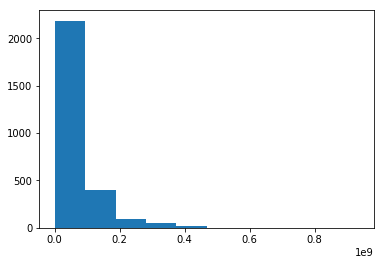

In [49]:
#Out of the 510 writers, only 92 show a statistically significant (p>.05) mean total domestic gross over 0, and
# of those 92, none show this with more than 10 data points. Let's drop this variable
del df['url']
del df['Distributor']
del df['Genre']
del df['actor']
del df['director']
del df['writer']
del df['composer']
del df['Rating']
df = df[np.invert(np.isnan(df.RunTime))]
df['ReleaseDate'] = [(x - datetime(1980,3,27)).total_seconds() for x in df['ReleaseDate']]
saveY = deepcopy(df['totalDomesticGross']) #This will be important for validation later
plt.hist(df['totalDomesticGross'])

(array([  97.,  186.,  324.,  611.,  751.,  468.,  214.,   75.,   15.,    3.]),
 array([   5.48861139,   90.20369141,  174.91877143,  259.63385145,
         344.34893147,  429.06401149,  513.77909151,  598.49417154,
         683.20925156,  767.92433158,  852.6394116 ]),
 <a list of 10 Patch objects>)

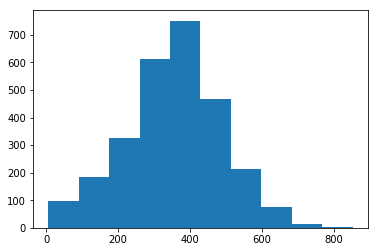

In [50]:
#This doesn't look normally distributed. Let's do a boxcox transformation.
lamb=stats.boxcox_normmax(df.totalDomesticGross, brack=(-1.9, 1.9), method='mle')
TDGlamb = lamb
df['totalDomesticGross']=(np.power(df.totalDomesticGross,lamb)-1)/lamb
plt.hist(df['totalDomesticGross'])

In [78]:
#Let's look at the correlations
df.corr()

,Budget,OpGross,ReleaseDate,RunTime,avOpGrossPTheater,noTheaters,totalDomesticGross
Budget,1.000,0.678,0.183,0.309,0.093,0.600,0.618
OpGross,0.678,1.000,0.232,0.194,0.080,0.640,0.729
ReleaseDate,0.183,0.232,1.000,0.003,0.026,0.330,0.113
RunTime,0.309,0.194,0.003,1.000,0.097,-0.001,0.231
avOpGrossPTheater,0.093,0.080,0.026,0.097,1.000,-0.191,0.200
noTheaters,0.600,0.640,0.330,-0.001,-0.191,1.000,0.697
totalDomesticGross,0.618,0.729,0.113,0.231,0.200,0.697,1.000


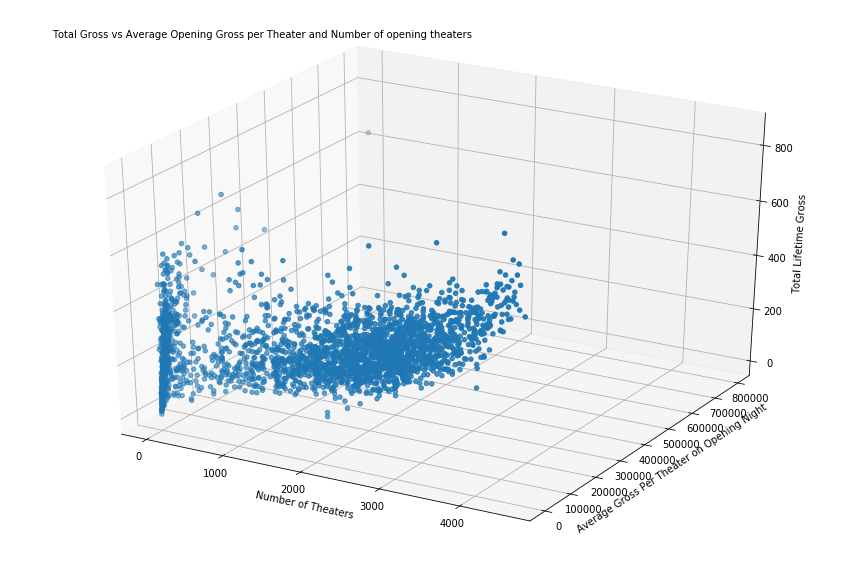

In [70]:
## Much better.  All of our features are now numeric.  Let's see if it will be useful to engineer interaction terms.
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['noTheaters'],df['avOpGrossPTheater'], df['totalDomesticGross'])
ax.set_ylabel('Average Gross Per Theater on Opening Night')
ax.set_xlabel('Number of Theaters')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)
        

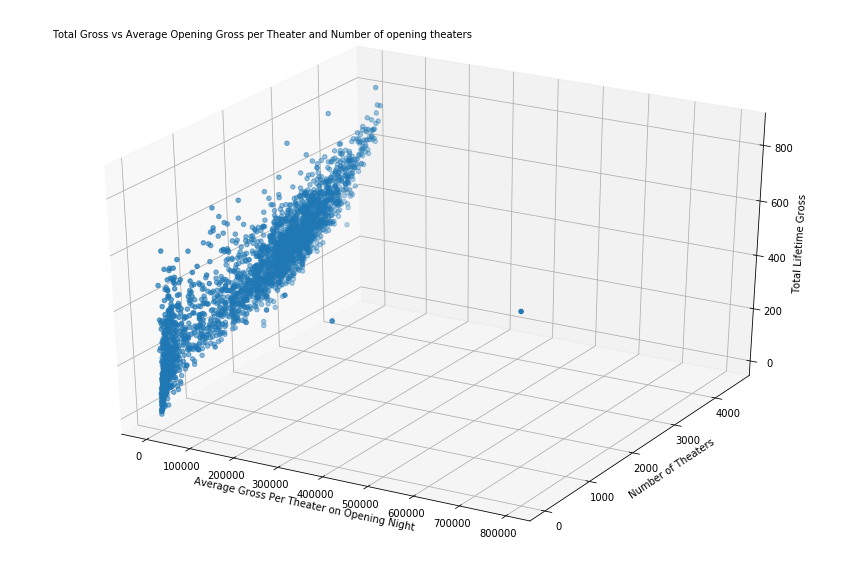

In [71]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['avOpGrossPTheater'],df['noTheaters'], df['totalDomesticGross'])
ax.set_ylabel('Number of Theaters')
ax.set_xlabel('Average Gross Per Theater on Opening Night')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)

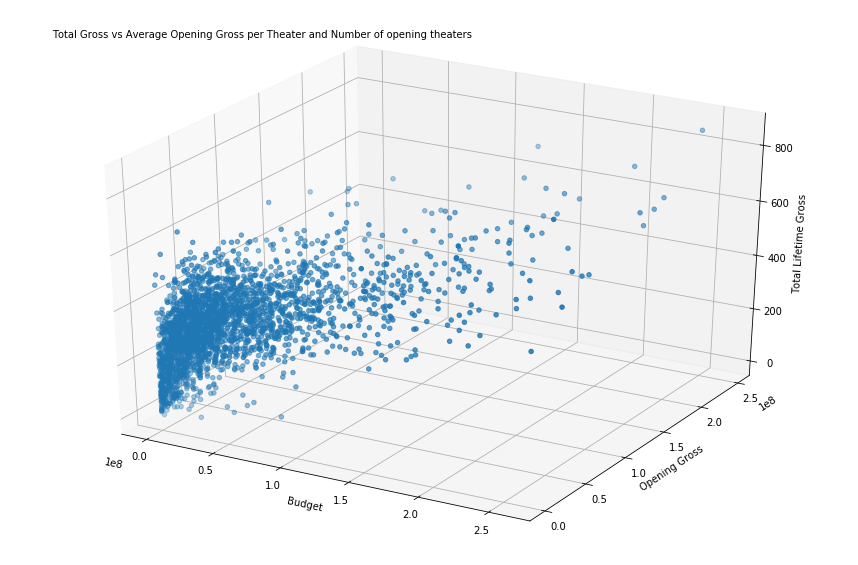

In [69]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['Budget'],df['OpGross'], df['totalDomesticGross'])
ax.set_ylabel('Opening Gross')
ax.set_xlabel('Budget')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)

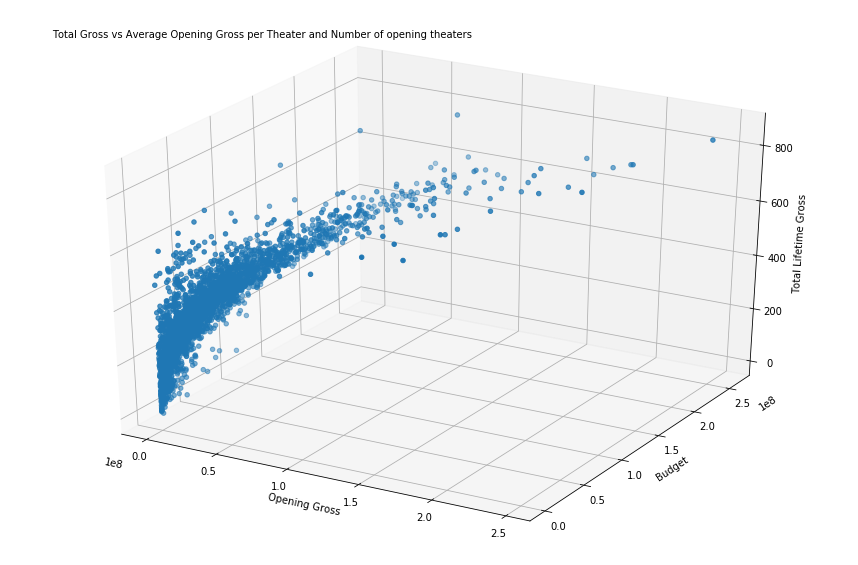

In [72]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['OpGross'],df['Budget'], df['totalDomesticGross'])
ax.set_ylabel('Budget')
ax.set_xlabel('Opening Gross')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)

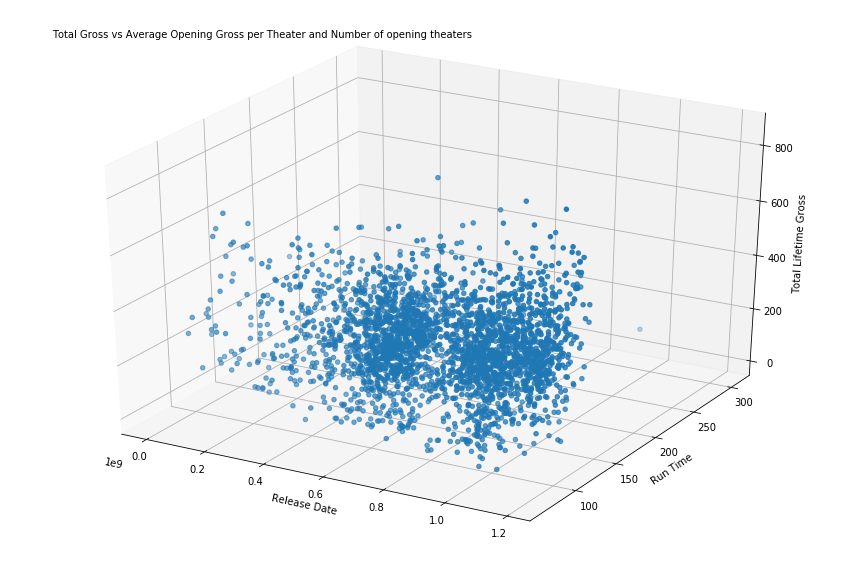

In [73]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['ReleaseDate'],df['RunTime'], df['totalDomesticGross'])
ax.set_ylabel('Run Time')
ax.set_xlabel('Release Date')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)

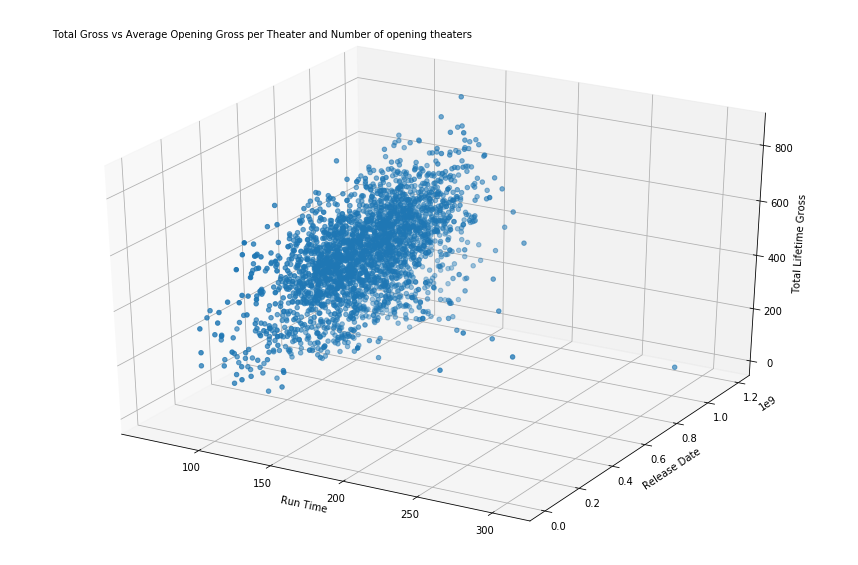

In [74]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['RunTime'],df['ReleaseDate'], df['totalDomesticGross'])
ax.set_ylabel('Release Date')
ax.set_xlabel('Run Time')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)

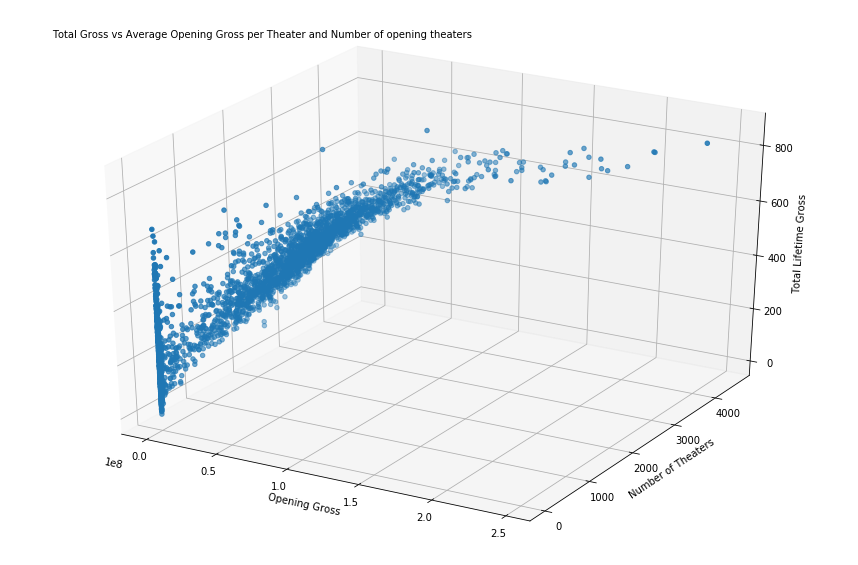

In [77]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['OpGross'],df['noTheaters'], df['totalDomesticGross'])
ax.set_ylabel('Number of Theaters')
ax.set_xlabel('Opening Gross')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)

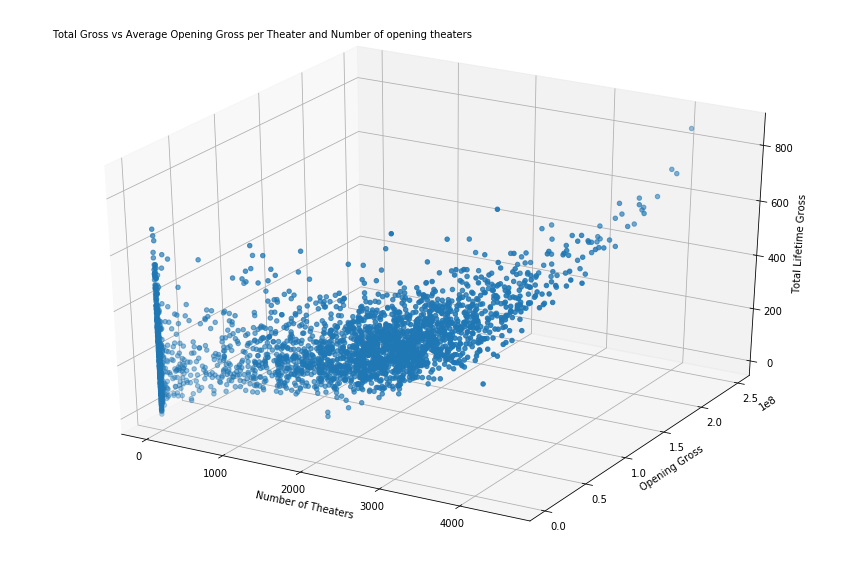

In [76]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['noTheaters'],df['OpGross'], df['totalDomesticGross'])
ax.set_ylabel('Opening Gross')
ax.set_xlabel('Number of Theaters')
ax.set_zlabel('Total Lifetime Gross')
plt.show(ax)

[ 16918.33686495   4645.70611688   2519.84312478   5516.07747321
   8580.54866724   5614.53027726]
[ 18521.52568216   5059.25432161   2844.07596845   3951.54682929
   4753.10737847   3988.49830566]
[-0.012652639257661358, 0.72192972642493014, 0.84917395774808535, 0.66983336150686035, 0.48640842634080073, 0.66394043641272238]


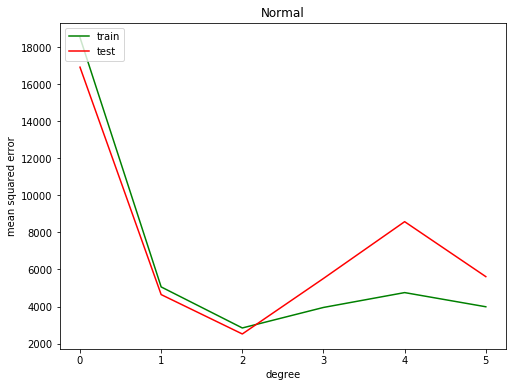

In [122]:
## Some of these plots indicate that it might be useful to have interaction terms in our regression model.
# How, though? If we try to increase the feature degree, the features will get large very quickly and this could
# lead to overfitting.
#Let's try taking fractional powers of the features.  If we took the square root of the features, for instance,
# and later took a linear model to degree two, we would get back our original features plus interaction terms without
# everything blowing up. Here's how a degree vs test error chart might look like without the square root:
%matplotlib inline
y = df['totalDomesticGross']
X = df[['Budget','OpGross','ReleaseDate','RunTime','avOpGrossPTheater','noTheaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3137)
scores = []
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))
    scores.append(est.score(X_test, y_test))
# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(6), train_error, color='green', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.title('Normal')
print(test_error)
print(train_error)
print(scores)

[ 16918.33686495   2336.61777081   1729.81186572   1903.79930072
   2303.8302523    4488.93653079]
[ 18521.52568216   2779.18183781   2007.84357174   1690.17770905
   1460.64989928   1282.76479461]
[-0.012652639257661358, 0.86014097180851712, 0.89646153961704222, 0.88604746424681102, 0.86210347955504185, 0.73131322176361402]


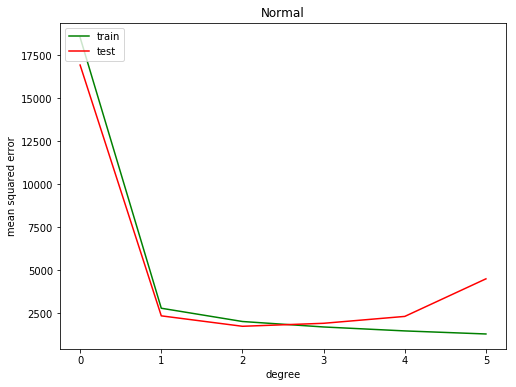

In [123]:
#lowest test MSE was 2519 for degree 2.  R^2 is decent, at .849 being the highest at degree 2.
#Let's try square rooting now:
%matplotlib inline
eg = deepcopy(df)
eg['Budget'] = np.power(df.Budget,(1.0/2))
eg['OpGross'] = np.power(df.OpGross,(1.0/2))
eg['ReleaseDate'] = np.power(df.ReleaseDate, (1.0/2))
eg['RunTime'] = np.power(df.RunTime, (1.0/2))
eg['avOpGrossPTheater'] = np.power(df.avOpGrossPTheater,(1.0/2))
eg['noTheaters'] = np.power(df.noTheaters, (1.0/2))
y = eg['totalDomesticGross']
X = eg[['Budget','OpGross','ReleaseDate','RunTime','avOpGrossPTheater','noTheaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3137)
scores = []
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))
    scores.append(est.score(X_test, y_test))
# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(6), train_error, color='green', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.title('Normal')
print(test_error)
print(train_error)
print(scores)

[ 16918.33686495   1897.75789787   1643.56029831   1783.13744841
   2412.60662382   8777.33740498]
[ 18521.52568216   2240.87382358   1898.37780229   1610.44611048
   1375.94320877   1210.87525451]
[-0.012652639257661358, 0.88640907440872252, 0.90162415566324494, 0.89326971925758647, 0.85559263392138984, 0.47462957146662893]


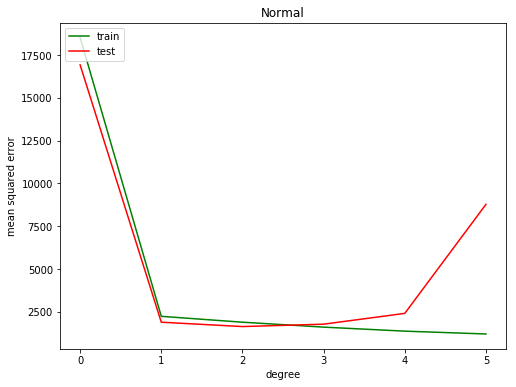

In [124]:
# So MSE went down by a lot, the lowest being 1729 at degree 2, with much improved r^2 at .896.
# Just for fun, let's extend the idea to cube roots:
%matplotlib inline
eg = deepcopy(df)
eg['Budget'] = np.power(df.Budget,(1.0/3))
eg['OpGross'] = np.power(df.OpGross,(1.0/3))
eg['ReleaseDate'] = np.power(df.ReleaseDate, (1.0/3))
eg['RunTime'] = np.power(df.RunTime, (1.0/3))
eg['avOpGrossPTheater'] = np.power(df.avOpGrossPTheater,(1.0/3))
eg['noTheaters'] = np.power(df.noTheaters, (1.0/3))
y = eg['totalDomesticGross']
X = eg[['Budget','OpGross','ReleaseDate','RunTime','avOpGrossPTheater','noTheaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3137)
scores = []
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))
    scores.append(est.score(X_test, y_test))
# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(6), train_error, color='green', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.title('Normal')
print(test_error)
print(train_error)
print(scores)

[ 16918.33686495   1803.76644094   1622.99383553   1701.94634513
   2503.8580637   14655.14112935]
[ 18521.52568216   2063.72158365   1862.09524172   1594.42198937
   1341.37799528   1088.70315903]
[-0.012652639257661358, 0.89203496409818095, 0.90285516808345057, 0.89812943955266566, 0.85013074885694218, 0.12281168877318183]


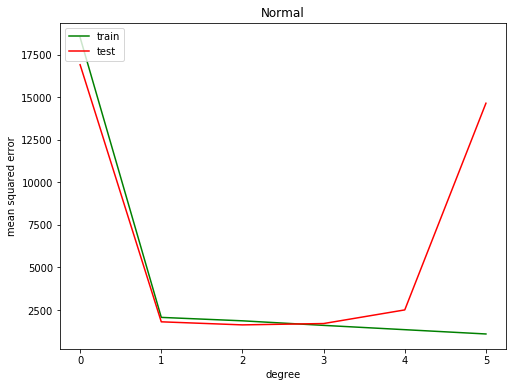

In [125]:
#More improvement: lowest MSE is 1643 at degree 2, with r^2 of .901 at the same. What about 6th roots?
%matplotlib inline
eg = deepcopy(df)
eg['Budget'] = np.power(df.Budget,(1.0/6))
eg['OpGross'] = np.power(df.OpGross,(1.0/6))
eg['ReleaseDate'] = np.power(df.ReleaseDate, (1.0/6))
eg['RunTime'] = np.power(df.RunTime, (1.0/6))
eg['avOpGrossPTheater'] = np.power(df.avOpGrossPTheater,(1.0/6))
eg['noTheaters'] = np.power(df.noTheaters, (1.0/6))
y = eg['totalDomesticGross']
X = eg[['Budget','OpGross','ReleaseDate','RunTime','avOpGrossPTheater','noTheaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3137)
scores = []
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))
    scores.append(est.score(X_test, y_test))
# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(6), train_error, color='green', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.title('Normal')
print(test_error)
print(train_error)
print(scores)

[ 16918.33686495   1995.29789901   1622.94721455   1700.36453285
   2506.49600283  33894.35198008]
[ 18521.52568216   2232.66141082   1856.01195599   1596.47916528
   1338.75139614   1058.4825014 ]
[-0.012652639257661358, 0.88057078543406908, 0.90285795859776441, 0.89822411944893876, 0.84997285413964885, -1.0287576292252245]


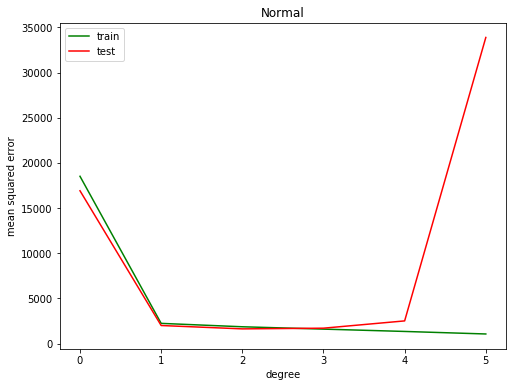

In [127]:
#Lowest MSE at 1622.99 at degree 2 with r^2 at .902855 at same.
# Let's try 18th roots and then call it a day:
%matplotlib inline
eg = deepcopy(df)
eg['Budget'] = np.power(df.Budget,(1.0/18))
eg['OpGross'] = np.power(df.OpGross,(1.0/18))
eg['ReleaseDate'] = np.power(df.ReleaseDate, (1.0/18))
eg['RunTime'] = np.power(df.RunTime, (1.0/18))
eg['avOpGrossPTheater'] = np.power(df.avOpGrossPTheater,(1.0/18))
eg['noTheaters'] = np.power(df.noTheaters, (1.0/18))
y = eg['totalDomesticGross']
X = eg[['Budget','OpGross','ReleaseDate','RunTime','avOpGrossPTheater','noTheaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3137)
scores = []
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))
    scores.append(est.score(X_test, y_test))
# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(6), train_error, color='green', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.title('Normal')
print(test_error)
print(train_error)
print(scores)

In [128]:
#Lowest MSE yet at 1622.94, with r^2 at .902857, both at degree 2.
#Let's move forward with our modeling, with all our features taken to the 18th root.
#First, let's try OLS models with degrees from 1 through 3.
MSEscores = []
Rscores = []
MAEscores = []
trials = 50
for degree in range(1,4):
    MSEscore = 0
    Rscore = 0
    MAEscore = 0
    for i in range(trials):
        est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        MSEscore +=np.mean(-cross_val_score(est, X, y, cv=10, scoring='mean_squared_error'))
        Rscore += np.mean(cross_val_score(est, X, y, cv = 10, scoring = 'r2'))
        MAEscore += np.mean(-cross_val_score(est, X, y, cv = 10, scoring = 'mean_absolute_error'))
    MSEscore /= trials
    Rscore /= trials
    MAEscore /=trials
    MSEscores.append(MSEscore)
    Rscores.append(Rscore)
    MAEscores.append(MAEscore)
    
print(MSEscores)
print(Rscores)
print(MAEscores)

[2207.6019767616558, 2035.4007726540699, 3781.193336503085]
[0.87323780305997656, 0.88306978683090165, 0.79750519661068164]
[33.277083879733198, 31.240242576582119, 31.251938586458895]


In [130]:
#With OLS, the best MSE is at degree 2, at 2035. MAE at 31.24 and R^2 at .883 at same. Let's try Ridge.
#We'll do 15 trials instead of 50 because this loop takes a bit longer:
alphs = [1 * 10**e for e in range(-8,3)]
MSEscores = []
Rscores = []
MAEscores = []
trials = 15
for degree in range(1,4):
    MSEscore = 0
    Rscore = 0
    MAEscore = 0
    for i in range(trials):
        est = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas = alphs, cv = 10))
        MSEscore +=np.mean(-cross_val_score(est, X, y, cv=10, scoring='mean_squared_error'))
        Rscore += np.mean(cross_val_score(est, X, y, cv = 10, scoring = 'r2'))
        MAEscore += np.mean(-cross_val_score(est, X, y, cv = 10, scoring = 'mean_absolute_error'))
    MSEscore /= trials
    Rscore /= trials
    MAEscore /=trials
    MSEscores.append(MSEscore)
    Rscores.append(Rscore)
    MAEscores.append(MAEscore)
    
print(MSEscores)
print(Rscores)
print(MAEscores)

[2208.5106914198445, 1941.8156427403153, 1961.9656816997704]
[0.87321074367804807, 0.88804829932562024, 0.88706873377125739]
[33.264066792722829, 30.519666983531451, 30.332568224885531]


In [132]:
#With Ridge, the best MSE is at degree 2, at 1941. MAE at 30.5297 and R^2 at .888 at same. Let's try Lasso.
#Again, 15 trials instead of 50 because the loop takes a bit longer than OLS
alphs = [1 * 10**e for e in range(-8,3)]
MSEscores = []
Rscores = []
MAEscores = []
trials = 15
for degree in range(1,4):
    MSEscore = 0
    Rscore = 0
    MAEscore = 0
    for i in range(trials):
        est = make_pipeline(PolynomialFeatures(degree), LassoCV(alphas = alphs, cv = 10))
        MSEscore +=np.mean(-cross_val_score(est, X, y, cv=10, scoring='mean_squared_error'))
        Rscore += np.mean(cross_val_score(est, X, y, cv = 10, scoring = 'r2'))
        MAEscore += np.mean(-cross_val_score(est, X, y, cv = 10, scoring = 'mean_absolute_error'))
    MSEscore /= trials
    Rscore /= trials
    MAEscore /=trials
    MSEscores.append(MSEscore)
    Rscores.append(Rscore)
    MAEscores.append(MAEscore)
    
print(MSEscores)
print(Rscores)
print(MAEscores)

[2209.9428353635185, 1955.8204675076988, 1956.2128392643654]
[0.87313459533753823, 0.88701095602273472, 0.88696608732480664]
[33.272408840285614, 31.024306364715759, 30.911137794478275]


In [134]:
#With Lasso, the best MSE is at 1956 at degree 2, with R^2 at .887 and MAE at 31.024 at same. Let's try Elastic Net.
#Again, 15 trials instead of 50 because the loop takes a bit longer to run than OLS
alphs = [1 * 10**e for e in range(-8,3)]
MSEscores = []
Rscores = []
MAEscores = []
trials = 15
for degree in range(1,4):
    MSEscore = 0
    Rscore = 0
    MAEscore = 0
    for i in range(trials):
        est = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(alphas = alphs, cv = 10))
        MSEscore +=np.mean(-cross_val_score(est, X, y, cv=10, scoring='mean_squared_error'))
        Rscore += np.mean(cross_val_score(est, X, y, cv = 10, scoring = 'r2'))
        MAEscore += np.mean(-cross_val_score(est, X, y, cv = 10, scoring = 'mean_absolute_error'))
    MSEscore /= trials
    Rscore /= trials
    MAEscore /=trials
    MSEscores.append(MSEscore)
    Rscores.append(Rscore)
    MAEscores.append(MAEscore)
    
print(MSEscores)
print(Rscores)
print(MAEscores)

[2208.5290250089233, 1958.6050714356347, 1956.6371836393373]
[0.87320402031141819, 0.88686781846068274, 0.88694786426505168]
[33.274573382776182, 31.043254351903578, 30.922500181423274]


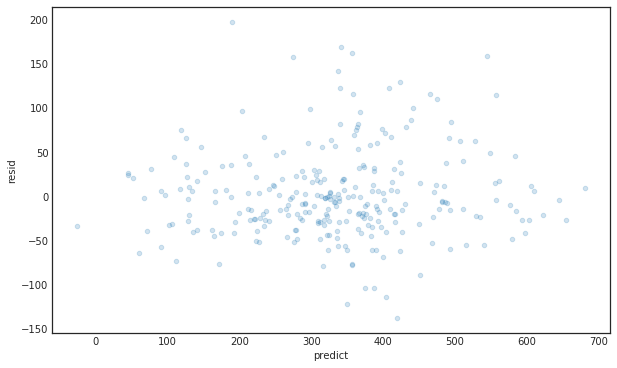

In [135]:
#Lowest MSE,MAE, and highest R^2 at degree 2 for Elastic Net at 1958, 31.04, and .886, respectively.
#So, Ridge at degree 2 performed the best out of all the models we tried.  Let's run diagnostics to make sure
#The noise is normal:
est = make_pipeline(PolynomialFeatures(2), RidgeCV(alphas = alphs, cv = 10))
est.fit(X, y)
Diag = pd.DataFrame()
Diag['predict']= est.predict(X)
Diag['resid']=y-est.predict(X)
with sns.axes_style('white'):
    plot=Diag.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

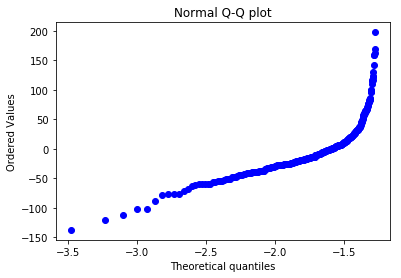

In [136]:
#Looks good. Let's try the q-q plot:
stats.probplot(Diag['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [154]:
#Not the best, but not much to do about it.
#Now, we need to get an estimate of our real world error rate. We don't want information leakage so:
#Let's do a test/train split, boxcox the training set, build the model with the same process above, and use the
#test set to estimate error.
X_train, X_test, y_train, y_test = train_test_split(X, saveY)
y_real = deepcopy(y_test)
lamb=stats.boxcox_normmax(y_train, brack=(-1.9, 1.9), method='mle')
y_train=(np.power(y_train,lamb)-1)/lamb
est = make_pipeline(PolynomialFeatures(2), RidgeCV(alphas = alphs, cv = 10))
est.fit(X_train, y_train)
y_predicted = est.predict(X_test)
y_predictedReal = np.power([1 + x for x in (lamb*y_predicted)],(1./lamb))
y_predictedReal = [0 if np.isnan(x) else x for x in y_predictedReal]
print(r2_score(y_real, y_predictedReal))
print(np.sqrt(mean_squared_error(y_real, y_predictedReal)))
print(mean_absolute_error(y_real, y_predictedReal))

0.866047908836
29603199.4447
15487777.4811


In [ ]:
## In conclusion: Our model is: a set of 6 features raised to the power 1/18, predicting via a Ridge model with
##polynomial degree two the boxcoxed total domestic gross dependent variable.  The estimated r^2 of this model
## out in the real world is .866.  The estimated root mean squared error out in the real world is , and the estimated
## mean absolute error out in the real world is